In [1]:
from __future__ import print_function

%matplotlib inline
from pyuvdata import UVData
from pyuvdata import UVCal
import os
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
from matplotlib import pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, Angle
from astropy.time import Time
import matplotlib.animation as anm
from scipy.interpolate import interp1d

In [100]:
#### Default Input Parameters ####

#Path to FHD run:
#path1 = "/lustre/aoc/projects/hera/dstorer/H3C_data/2458787/FHD_Output/streakOff"
path1 = "/lustre/aoc/projects/hera/dstorer/H3C_data/2458791/fhdOutput/newShapeDict"
ssinsPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458791/ssinsFlagged/newShapeDict'
#JDs to execute on (assumes FHD results are organized into sub-directories by these names within path1)
days = ['2458791']
#ant_nums = [51,70,52,53] #Antenna numbers to read in
ant_nums = [11,12]
baselines = [(11,11),(12,12),(11,12),(118,118),(12,118),(13,13),(13,118)]
plotName = 'H3C_SSINSFlagged_StreakOn' #Base name for plots
#outpath = "/lustre/aoc/projects/hera/dstorer/H3C_data/2458787/FHD_Output/streakOn/plots/" #Output directory for plots
frame_baseName = 'calMovieFrames' #Base name for movie frames
pol = 'Jxx' #Polarization to read in
freqrange=[120,185] #Frequency range (MHz) to read in and plot
visrange=[1,-1] #Range (indices) of observations array to read in and plot
colormap = 'plasma_r'
#Source to read calibration from (Either 'sav' for FHD .sav files, or 'fits' for UVCal cal.fits files:
#Note that for cal.fits files I assume they are stored in the calibration subdirectory with the same naming convention
source = 'sav'
#Option to write out a calfits file:
write_calfits = False



In [86]:
#### Setup paths and arrays ####

thedir = path1
vis = [name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name))]
vis.sort()
vis = vis[1:-1]
obspath = path1 + '/' + vis[9]
data_array = {}

In [87]:
#Get telescope location:
dat = UVData()
version = vis[9]
print(version)
obsid = version[4:-26]
print(obsid)
prefix = obspath + '/' + 'metadata' + '/' + obsid + '_'
files1 = [prefix + f for f in ['params.sav','settings.txt']]
prefix = obspath + '/' + 'vis_data' + '/' + obsid + '_'
files2 = [prefix + f for f in ['flags.sav','vis_XX.sav','vis_YY.sav','vis_model_XX.sav','vis_model_YY.sav']]
files = np.append(files1, files2)

dat.read_fhd(files)
loc = EarthLocation.from_geocentric(*dat.telescope_location, unit='m')

fhd_2458791.4246153915_H3C_ssinsFlagged_streakON
2458791.4246153915


In [88]:
def get_zenithRA(time_array,telescope_location):
    zens = []
    for t in time_array:
        if t is None:
            zens.append(zens[-1] + (zens[-1]-zens[-2]))
        else:
            zen = SkyCoord(Angle(0, unit='deg'),Angle(90,unit='deg'),frame='altaz',obstime=t,location=telescope_location)
            zen = zen.transform_to('icrs')
            zen = zen.ra.degree
            zens.append(zen)
    return zens

In [89]:
def get_LSTs(time_array):
    lst_arr = []
    for i in range(len(time_array)):
        t = time_array[i]
        if t is not None:
            lst = t.sidereal_time('mean').hour
            lst_arr.append(lst)
        else:
            if i == 0:
                lst = 0
            else:
                lst = lst_arr[-1]+0.0139
            lst_arr.append(lst)
    return lst_arr

In [98]:
def readFHDVisibilities(baselines=baselines, days=days, path1=path1, polarization='XX'):
    vis_array = {}
    for k in range(len(days)):
        day_array = {}
        for b in baselines:
            day_array[b] = []
        vis = [ name for name in os.listdir(path1) if os.path.isdir(os.path.join(path1, name)) ]
        vis.sort()
        vis = vis[visrange[0]:visrange[1]]
        for i in range(len(vis)):
            v = vis[i]
            obs = v[4:-26]
            print(obs)
            path = '%s/%s' % (path1,v)
            if os.path.exists(path + '/vis_data/') is False:
                continue
            uv = UVData()
            fhd_files = []
            fhd_files.append(path + '/metadata/' + obs + '_params.sav')
            fhd_files.append(path + '/metadata/' + obs + '_settings.txt')
            vis_files = ['flags.sav','vis_XX.sav','vis_YY.sav','vis_model_XX.sav','vis_model_YY.sav']
            for f in vis_files:
                fhd_files.append(path + '/vis_data/' + obs + '_' + f)
            uv.read_fhd(fhd_files)
            for b in baselines:
                #print('(%i,%i)' % (b[0],b[1]))
                vis_data = uv.get_data(b[0], b[1], polarization)
                for x in vis_data[:]:
                    day_array[b].append(x)
        vis_array[days[k]] = day_array
    return vis_array

In [103]:
def readRawVisibilities(baselines=baselines, days=days, path1=ssinsPath, polarization='XX'):
    vis_array = {}
    for k in range(len(days)):
        day_array = {}
        for b in baselines:
            day_array[b] = []
        vis = [ name for name in os.listdir(path1) if name.endswith(".uvh5") ]
        vis.sort()
        for i in range(len(vis)):
            v = vis[i]
            obs = v[4:-33]
            print(obs)
            path = '%s/%s' % (path1,v)
            uv = UVData()
            uv.read(path)
            for b in baselines:
                vis_data = uv.get_data(b[0], b[1], polarization)
                for x in vis_data[:]:
                    day_array[b].append(x)
        vis_array[days[k]] = day_array
    return vis_array

In [ ]:
raw_vis_array = readRawVisibilities()

2458791.42126
2458791.42361
2458791.42596
2458791.42831
2458791.43066
2458791.43300
2458791.43535
2458791.43770
2458791.44005
2458791.44240
2458791.44475
2458791.44710
2458791.44945
2458791.45179
2458791.45414
2458791.45649
2458791.45884
2458791.46119
2458791.46354
2458791.46589
2458791.46824
2458791.47058


In [91]:
vis_array = readFHDVisibilities()

2458791.421595493
2458791.421931037
2458791.4222665816
2458791.422602126
2458791.4229376703
2458791.4232732146
2458791.4236087585
2458791.423944303
2458791.424279847
2458791.4246153915
2458791.424950936
2458791.42528648
2458791.4256220246
2458791.425957569
2458791.4262931133
2458791.4266286576
2458791.426964202
2458791.4272997463
2458791.4276352907
2458791.427970835
2458791.4283063794
2458791.4286419237
2458791.428977468
2458791.429313012
2458791.4296485563
2458791.4299841006
2458791.430319645
2458791.4306551893
2458791.4309907337
2458791.431326278
2458791.4316618224
2458791.4319973667
2458791.432332911
2458791.4326684554
2458791.4330039998
2458791.433339544
2458791.4336750885
2458791.434010633
2458791.434346177
2458791.4346817215
2458791.4350172654
2458791.4353528097
2458791.435688354
2458791.4360238984
2458791.436359443
2458791.436694987
2458791.4370305315
2458791.437366076
2458791.43770162
2458791.4380371645
2458791.438372709
2458791.438708253
2458791.4390437976
2458791.439379342
24

2458791.5705771707
2458791.570912715
2458791.5712482594
2458791.5715838037
2458791.571919348
2458791.5722548924
2458791.572590437
2458791.572925981
2458791.5732615255
2458791.57359707
2458791.573932614
2458791.5742681585
2458791.574603703
2458791.574939247
2458791.5752747916
2458791.5756103355
2458791.57594588
2458791.576281424
2458791.5766169685
2458791.576952513
2458791.577288057
2458791.5776236015
2458791.577959146
2458791.57829469
2458791.5786302346
2458791.578965779
2458791.5793013233
2458791.5796368676
2458791.579972412
2458791.5803079563
2458791.5806435007
2458791.580979045
2458791.581314589
2458791.5816501332
2458791.5819856776
2458791.582321222
2458791.5826567663
2458791.5829923106
2458791.583327855
2458791.5836633993
2458791.5839989437
2458791.584334488
2458791.5846700324
2458791.5850055767
2458791.585341121
2458791.5856766654
2458791.5860122098
2458791.586347754
2458791.5866832985
2458791.5870188423
2458791.5873543867
2458791.587689931
2458791.5880254754
2458791.5883610197
2

(1536,)


(0, 1000)

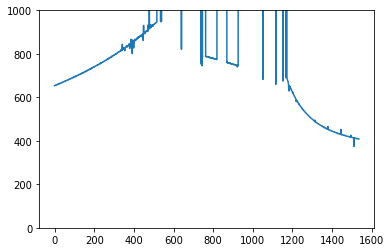

In [84]:
dat = vis_array[days[0]][(12,12)]
print(np.shape(dat[850]))
fig = plt.figure()
plt.plot(np.abs(dat[850]))
plt.ylim((0,1000))

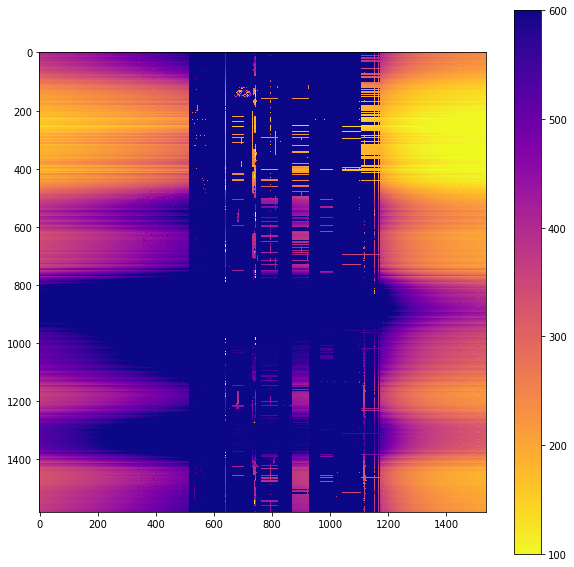

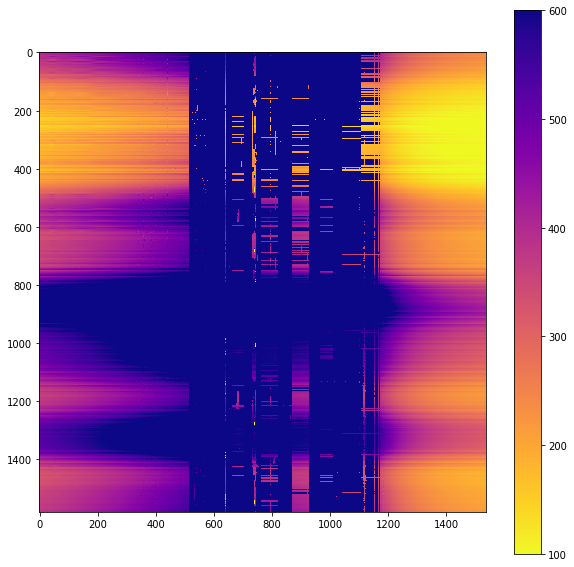

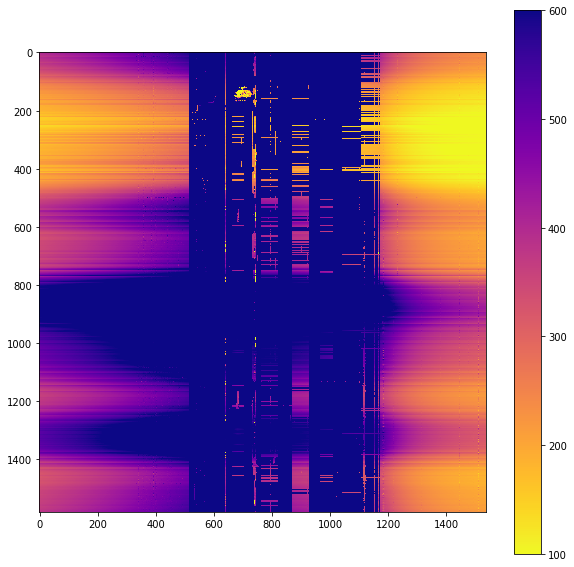

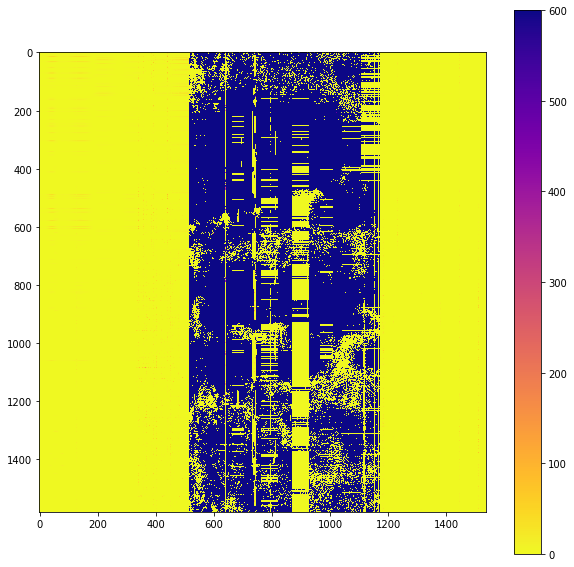

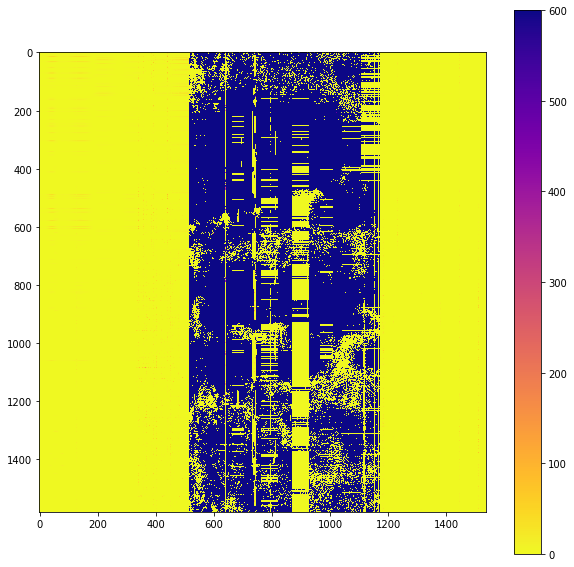

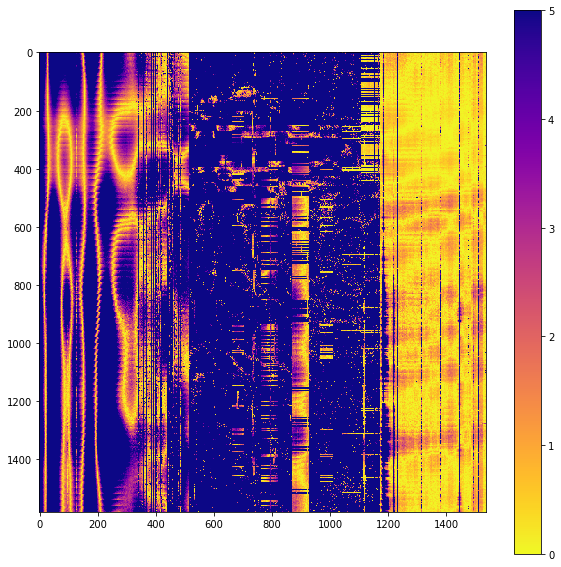

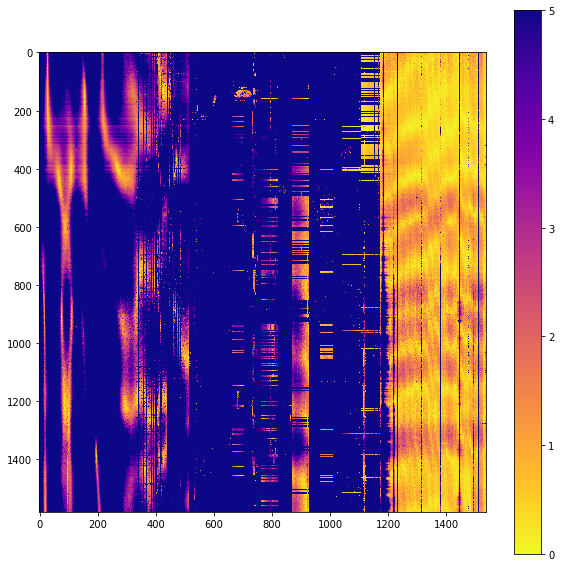

In [96]:
fig = plt.figure(figsize=(10,10))
dat11 = vis_array[days[0]][(11,11)]
#print(dat)
datReal = np.abs(np.real(dat11))
datAmp = np.abs(dat11)
plt.imshow(datAmp, cmap=colormap, vmin=100,vmax=600)
plt.colorbar()

fig = plt.figure(figsize=(10,10))
dat118 = vis_array[days[0]][(118,118)]
datReal = np.abs(np.real(dat118))
datAmp = np.abs(dat118)
plt.imshow(datAmp, cmap=colormap, vmin=100,vmax=600)
plt.colorbar()

fig = plt.figure(figsize=(10,10))
dat13 = vis_array[days[0]][(13,13)]
datReal = np.abs(np.real(dat13))
datAmp = np.abs(dat13)
plt.imshow(datAmp, cmap=colormap, vmin=100,vmax=600)
plt.colorbar()

datSub = np.abs(dat118) - np.abs(dat11)
fig = plt.figure(figsize=(10,10))
plt.imshow(datSub, cmap=colormap, vmin=0,vmax=600)
plt.colorbar()

datSub2 = np.abs(dat118) - np.abs(dat13)
fig = plt.figure(figsize=(10,10))
plt.imshow(datSub, cmap=colormap, vmin=0,vmax=600)
plt.colorbar()

fig = plt.figure(figsize=(10,10))
dat = vis_array[days[0]][(11,12)]
datReal = np.abs(np.real(dat))
datAmp = np.abs(dat)
plt.imshow(datReal, cmap=colormap, vmin=0,vmax=5)
plt.colorbar()
fig = plt.figure(figsize=(10,10))
plt.imshow(datAmp, cmap=colormap, vmin=0,vmax=5)
plt.colorbar()

In [ ]:
def readCalSolutions(ant_nums=ant_nums, days=days, path1=path1, source=source):
    cal = UVCal()
    nants = len(ant_nums)
    for k in range(len(days)):
        day_array = {}
        thedir = path1
        vis = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
        vis.sort()
        vis = vis[visrange[0]:visrange[1]]
        for j in range(nants):
            nocal = 0
            i=0
            times = []
            for v in vis:
                data = True
                obs = v[4:-26]
                print('Reading data for antenna ' + str(ant_nums[j]) + ', Obs ' + str(obs))
                path = path1 + '/' + v
                if os.path.exists(path + '/calibration/') is False:
                    print('!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!')
                    print('There is no calibration data for this observation. The gains for this observation will be entered as 0.')
                    nocal = nocal + 1
                    data = False
                    times.append(None)
                if source == 'sav':
                    if data == True:
                        obsfile = path + '/metadata/' + obs + '_obs.sav'
                        calfile = path + '/calibration/' + obs + '_cal.sav'
                        settingsfile = path + '/metadata/' + obs + '_settings.txt'
                        cal.read_fhd_cal(calfile,obsfile,settings_file=settingsfile)
                elif source == 'fits':
                    calfits = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                    cal.read_calfits(calfits)
                else:
                    print('####################### ERROR #####################')
                    print('The source must be set to either sav or fits')
                if write_calfits == True and data == True:
                    outpath = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                    cal.write_calfits(outpath, clobber=True)
                if i == 0 and data==True:
                    nobs = len(vis)
                    nfreqs = cal.Nfreqs
                    freq_array = cal.freq_array[0,:]
                    freq_array = np.transpose(freq_array)
                    freq_array = np.divide(freq_array,1000000)
                    minfreqind = np.argmax(freq_array>freqrange[0])
                    maxfreqind = np.argmin(freq_array<freqrange[1])
                    cal_array = np.empty((nfreqs,nobs))
                    mask_array = np.zeros((nfreqs,nobs))
                    if j == 0:
                        ## Get the LST start and end times for this obsid ##
                        time_array = cal.time_array
                        obstime_start = Time(time_array[0],format='jd',location=loc)
                        startTime = obstime_start.sidereal_time('mean').hour
                        JD = int(obstime_start.jd)
                if v == vis[-1] and j == 0:
                    time_array = cal.time_array
                    obstime_end = Time(time_array[-1],format='jd',location=loc)
                    endTime = obstime_end.sidereal_time('mean').hour
                if data is True:
                    gain = np.abs(cal.get_gains(ant_nums[j], pol))
                if data is False:
                    if i == 0:
                        continue
                    else:
                        gain = np.zeros(np.shape(gain))
                        cal_array[:,i] = gain[:,0]
                        mask_array[:,i] = np.ones(np.shape(gain))[:,0]
                        i = i + 1
                        continue
                cal_array[:,i] = gain[:,0]
                i = i + 1
                tArr = cal.time_array
                t = Time(tArr[0],format='jd',location=loc)
                times.append(t)
            cal_array = np.transpose(cal_array)
            mask_array = np.transpose(mask_array)
            cal_array = cal_array[:,minfreqind:maxfreqind]
            mask_array = mask_array[:,minfreqind:maxfreqind]
            ## Getting max and min values ##
            calsort = np.sort(cal_array)
            maxind = int(len(calsort[0])/15)
            maxuse = calsort[:,-maxind]
            maxuse = np.max(maxuse)
            if maxuse >=5:
                    maxind = int(len(calsort[0])/12)
                    maxuse = calsort[:,-maxind]
                    maxuse = np.max(maxuse)
                    print('!!!!!!!!!!!!!!!!!!! Had to adjust max used value !!!!!!!!!!!!!!!!!!!')
            maxval = np.max(calsort[:,-1])
            print('Maximum gain value is: ' + str(maxval))
            print('Maximum gain value used is: ' + str(maxuse))
            freq_array = freq_array[minfreqind:maxfreqind]
            mx = np.ma.masked_array(cal_array, mask=mask_array)
            lst_array = get_LSTs(times)
            zenith_RAs = get_zenithRA(times,loc)
            res = {
                    "ant_num": ant_nums[j],
                    "obsid": obs,
                    "cal_array": cal_array,
                    "time_array": times,
                    "freq_array": freq_array,
                    "masked_data": mx,
                    "zenith_RA_array": zenith_RAs,
                    "lst_array": lst_array,
                    "pol": pol
                }
            antenna = ant_nums[j]
            day_array[antenna] = res
            print('###############################################################')
            print('Out of ' + str(len(vis)) + ' observations, ' + str(nocal) + ' did not contain calibration solutions')
            print('###############################################################')
        data_array[days[k]] = day_array
    return data_array

In [9]:
dat = readData()

Reading data for antenna 11, Obs 2458791.421595493
Reading data for antenna 11, Obs 2458791.421931037
Reading data for antenna 11, Obs 2458791.4222665816
Reading data for antenna 11, Obs 2458791.422602126
Reading data for antenna 11, Obs 2458791.4229376703
Reading data for antenna 11, Obs 2458791.4232732146
Reading data for antenna 11, Obs 2458791.4236087585
Reading data for antenna 11, Obs 2458791.423944303
Reading data for antenna 11, Obs 2458791.424279847
Reading data for antenna 11, Obs 2458791.4246153915
Reading data for antenna 11, Obs 2458791.424950936
Reading data for antenna 11, Obs 2458791.42528648
Reading data for antenna 11, Obs 2458791.4256220246
Reading data for antenna 11, Obs 2458791.425957569
Reading data for antenna 11, Obs 2458791.4262931133
Reading data for antenna 11, Obs 2458791.4266286576
Reading data for antenna 11, Obs 2458791.426964202
Reading data for antenna 11, Obs 2458791.4272997463
Reading data for antenna 11, Obs 2458791.4276352907
Reading data for anten

Reading data for antenna 11, Obs 2458791.4682361535
Reading data for antenna 11, Obs 2458791.4685716974
Reading data for antenna 11, Obs 2458791.4689072417
Reading data for antenna 11, Obs 2458791.469242786
Reading data for antenna 11, Obs 2458791.4695783304
Reading data for antenna 11, Obs 2458791.4699138748
Reading data for antenna 11, Obs 2458791.470249419
Reading data for antenna 11, Obs 2458791.4705849634
Reading data for antenna 11, Obs 2458791.470920508
Reading data for antenna 11, Obs 2458791.471256052
Reading data for antenna 11, Obs 2458791.4715915965
Reading data for antenna 11, Obs 2458791.471927141
Reading data for antenna 11, Obs 2458791.472262685
Reading data for antenna 11, Obs 2458791.4725982295
Reading data for antenna 11, Obs 2458791.472933774
Reading data for antenna 11, Obs 2458791.473269318
Reading data for antenna 11, Obs 2458791.4736048626
Reading data for antenna 11, Obs 2458791.473940407
Reading data for antenna 11, Obs 2458791.474275951
Reading data for anten

Reading data for antenna 11, Obs 2458791.5199099784
Reading data for antenna 11, Obs 2458791.5202455227
Reading data for antenna 11, Obs 2458791.520581067
Reading data for antenna 11, Obs 2458791.5209166114
Reading data for antenna 11, Obs 2458791.521252156
Reading data for antenna 11, Obs 2458791.5215877
Reading data for antenna 11, Obs 2458791.5219232445
Reading data for antenna 11, Obs 2458791.522258789
Reading data for antenna 11, Obs 2458791.522594333
Reading data for antenna 11, Obs 2458791.5229298775
Reading data for antenna 11, Obs 2458791.523265422
Reading data for antenna 11, Obs 2458791.523600966
Reading data for antenna 11, Obs 2458791.5239365106
Reading data for antenna 11, Obs 2458791.524272055
Reading data for antenna 11, Obs 2458791.5246075992
Reading data for antenna 11, Obs 2458791.524943143
Reading data for antenna 11, Obs 2458791.5252786875
Reading data for antenna 11, Obs 2458791.525614232
Reading data for antenna 11, Obs 2458791.525949776
Reading data for antenna 

Reading data for antenna 11, Obs 2458791.572590437
Reading data for antenna 11, Obs 2458791.572925981
Reading data for antenna 11, Obs 2458791.5732615255
Reading data for antenna 11, Obs 2458791.57359707
Reading data for antenna 11, Obs 2458791.573932614
Reading data for antenna 11, Obs 2458791.5742681585
Reading data for antenna 11, Obs 2458791.574603703
Reading data for antenna 11, Obs 2458791.574939247
Reading data for antenna 11, Obs 2458791.5752747916
Reading data for antenna 11, Obs 2458791.5756103355
Reading data for antenna 11, Obs 2458791.57594588
Reading data for antenna 11, Obs 2458791.576281424
Reading data for antenna 11, Obs 2458791.5766169685
Reading data for antenna 11, Obs 2458791.576952513
Reading data for antenna 11, Obs 2458791.577288057
Reading data for antenna 11, Obs 2458791.5776236015
Reading data for antenna 11, Obs 2458791.577959146
Reading data for antenna 11, Obs 2458791.57829469
Reading data for antenna 11, Obs 2458791.5786302346
Reading data for antenna 11

KeyboardInterrupt: 

In [29]:
def getClippedFrequency(freq_array,mx,freq_range=[120,180]):
    idx0 = (np.abs(freq_array - freq_range[0])).argmin()
    idx1 = (np.abs(freq_array - freq_range[1])).argmin()
    freq_array = freq_array[idx0:idx1]
    mx = mx[:,idx0:idx1]
    return mx, freq_array

In [30]:
def getClippedTime(time_array,mx,lst_range=[2,8]):
    idx0 = (np.abs(time_array - np.asarray(lst_range[0]))).argmin()
    idx1 = (np.abs(time_array - np.asarray(lst_range[1]))).argmin()
    time_array = time_array[idx0:idx1]
    mx = mx[idx0:idx1,:]
    return mx, time_array, idx0, idx1

In [46]:
def plotWaterfalls(data_array,saveFig=False,plotName='',firstFileLines=False,freq_range=[120,180],lst_range='all',days=days,vmin=0,vmax=1,ant_nums=ant_nums):
    nants = len(ant_nums)
    for k in range(len(days)):
        fig, axs = plt.subplots(1, nants, figsize=(15,6))
        fig.subplots_adjust(hspace=0.5,wspace=0.5)
        fig.subplots_adjust(right=0.8)
        for j in range(nants):
            ant = ant_nums[j]
            mx = data_array[days[k]][ant]["masked_data"]
            freq_array = data_array[days[k]][ant]["freq_array"]
            if not freq_range == 'all':
                mx, freq_array = getClippedFrequency(freq_array,mx,freq_range)
            else:
                freq_range = np.around([freq_array[0],freq_array[-1]],0)
                print(freq_range)
            time_array = data_array[days[k]][ant]["lst_array"]
            zens = data_array[days[k]][ant]["zenith_RA_array"]
            if not lst_range == 'all':
                mx, time_array, idx0, idx1 = getClippedTime(time_array,mx,lst_range)
                zens = zens[idx0:idx1]
            currmap = mpl.cm.get_cmap()
            currmap.set_bad('black',1.)
            im = axs[j].imshow(
                mx, origin='upper', interpolation='none',
                cmap = colormap,
                aspect='auto', vmin=vmin, vmax=vmax
            )
            JD = days[k]
            axs[j].set_title('Antenna #' + str(ant) + ', JD: ' + str(JD))
            axs[j].set_xlabel('Frequency (MHz)')
            df = (freq_range[-1] - freq_range[0])/6
            freq_ticks = np.around([freq_range[0],freq_range[0],freq_range[0]+df,freq_range[0]+2*df,freq_range[-1]-2*df,freq_range[-1]-df,freq_range[-1]],0)
            axs[j].set_xticklabels(freq_ticks)
            if j == 0:
                axs[j].set_ylabel('Time (LST)')
                idx = np.round(np.linspace(0,len(time_array)-1,10)).astype(int)
                time_ticks = np.around([time_array[i] for i in idx],1)
                axs[j].set_yticklabels(time_ticks)
            elif j == (nants-1):
                axs[j].set_ylabel('RA of zenith (deg)',rotation=270,labelpad=20)
                idx = np.round(np.linspace(0,len(zens)-1,10)).astype(int)
                zen_ticks = np.around([zens[i] for i in idx],1)
                axs[j].set_yticklabels(zen_ticks)
                axs[j].yaxis.tick_right()
                axs[j].yaxis.set_label_position("right")
            else:
                axs[j].get_yaxis().set_ticklabels([])
            if firstFileLines == True:
                i = np.mod(visrange[0],12)
                while i < len(time_array):
                    axs[j].axhline(i,color='lightsteelblue')
                    i = i + 12
        cbar_ax = fig.add_axes([0.87,0.1,0.02,0.8])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Gain Amplitude', rotation=270, labelpad=20)
        if saveFig == True:
            fig.savefig(outpath + str(days[k]) + '_waterfall_' + plotName)
            print('Saving figure to: ' + outpath + str(days[k]) + '_waterfall_' + plotName)

[120. 185.]
[120. 185.]


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


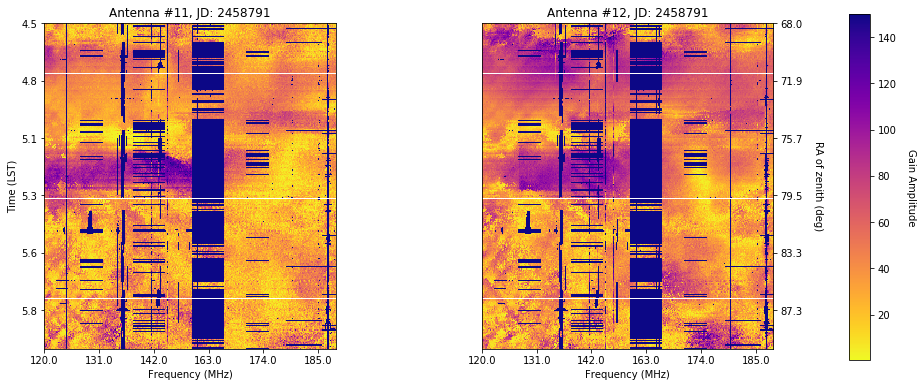

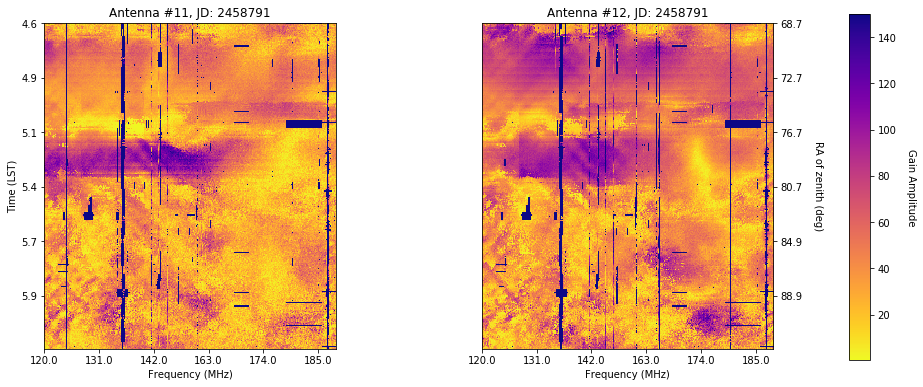

In [52]:
plotWaterfalls(data_array,firstFileLines=False,freq_range='all',vmin=0.5,vmax=150,ant_nums=[11,12],lst_range=[4.3,6.6])
plotWaterfalls(data_array_original,firstFileLines=False,freq_range='all',vmin=0.5,vmax=150,ant_nums=[11,12])
#plotWaterfalls(data_array_streakOn,firstFileLines=False,freq_range='all',vmin=0.5,vmax=75,ant_nums=[11,12])
mx = data_array[days[0]][11]["masked_data"]
#print(mx)
# print(np.shape(data_array['2458787'][70]["freq_array"]))
# print(np.shape(data_array['2458787'][70]["masked_data"]))
# print(data_array['2458787'][70]["masked_data"][0])

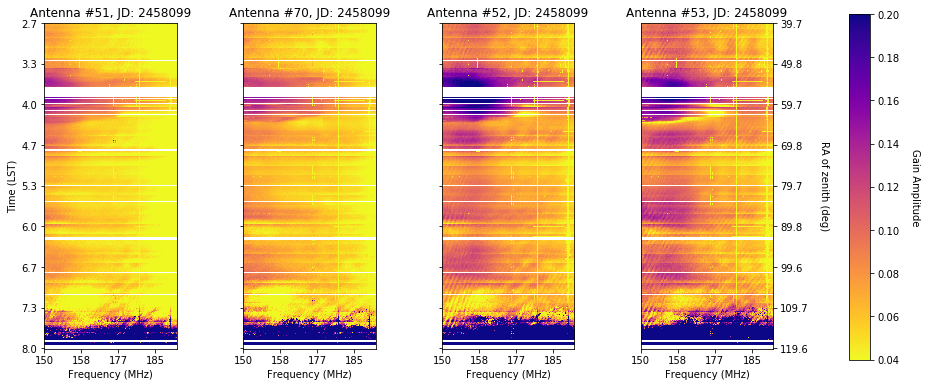

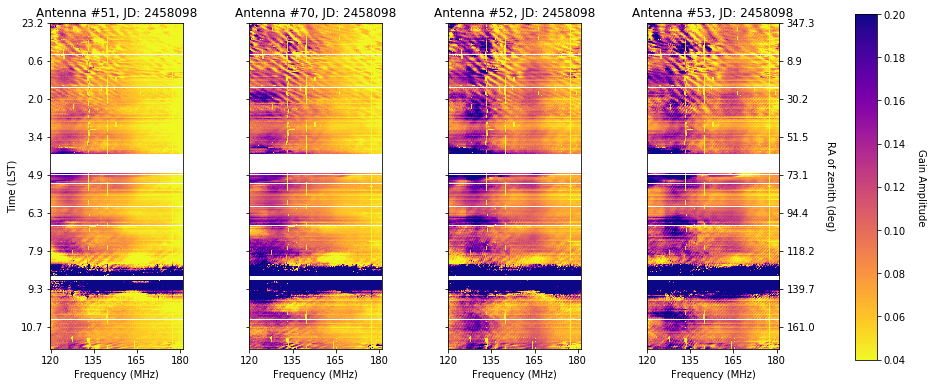

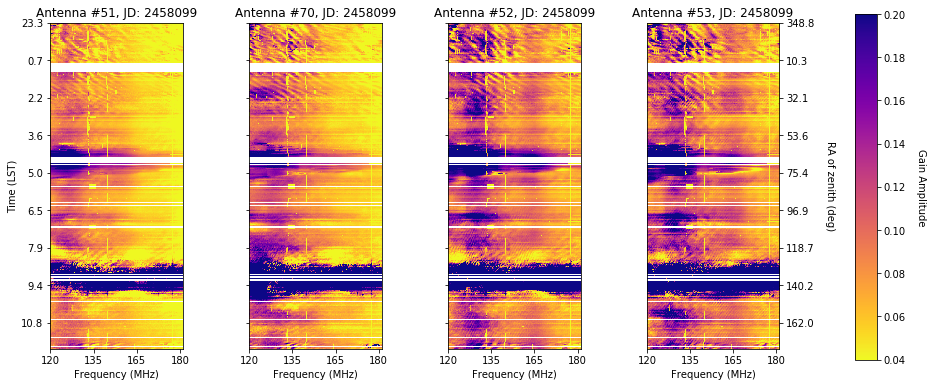

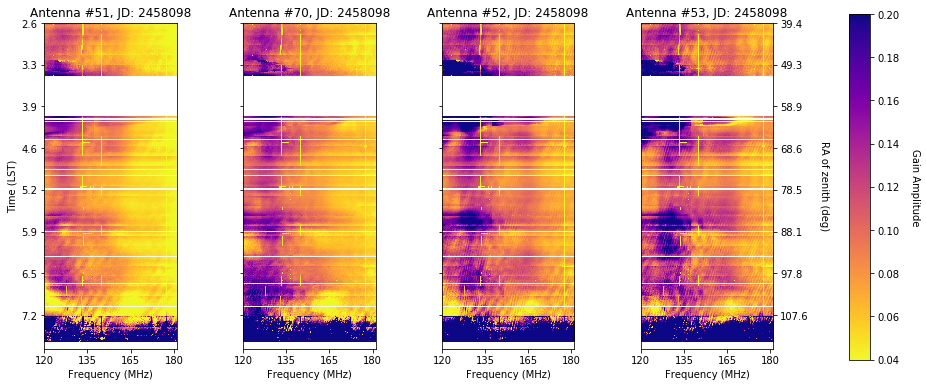

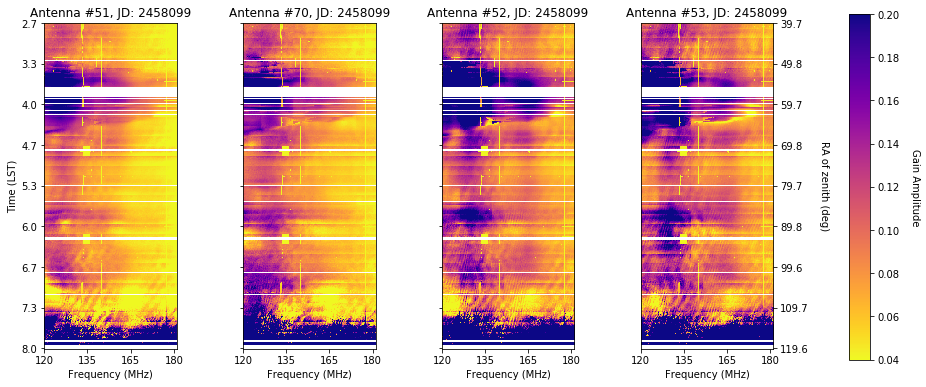

In [409]:
#plotWaterfalls(data_array,'withFileStartLines',firstFileLines=True,freq_range=[120,185],lst_range=[2,8])
#plotWaterfalls(data_array,'withoutFileStartLines',firstFileLines=False,freq_range=[120,185],lst_range=[2,8])
plotWaterfalls(data_array,firstFileLines=False,freq_range=[150,185],lst_range=[2,8],days=['2458099'])
#plotWaterfalls(data_array,firstFileLines=True,freq_range=[150,185],lst_range=[2,8],days=['2458099'])
plotWaterfalls(data_array,firstFileLines=False,freq_range=[120,180],lst_range='all')
plotWaterfalls(data_array,firstFileLines=False,freq_range=[120,180],lst_range=[2,8])

In [317]:
def plotMovieFrames_multiDay(data_array):
    for k in range(len(days)):
        fnames = str(days[k]) + '_' + frame_baseName
        fig, axs = plt.subplots(len(days),nants,figsize=(15,6))
        fig.subplots_adjust(hspace=0.5,wspace=0.5)
        fig.subplots_adjust(right=0.8)
        for t in range(len(vis)):
            for m in range(nants):
                ant = ant_nums[m]
                lbl = 'Antenna ' + str(ant)
                freq_array = data_array[days[k]][ant]['freq_array']
                axs[m].scatter(freq_array,data_array[days[k]][ant]['cal_array'][t,:],s=2,label=lbl)
            fname = fnames + '_' + str(t) + '.png'
            plt.title('Calibration Solutions for ' + days[k])
            plt.xlabel('Frequency (MHz)')
            plt.ylabel('Gain Amplitude')
            plt.ylim(0,0.3)
            plt.legend(loc='upper right')
            ax = plt.gca()
            currTime = data_array[days[k]][ant]['time_array'][t]
            timeStr = 'LST: ' + str(np.around(currTime,2))
            plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)
            plt.savefig(fname)
            plt.show()
            plt.cla()

In [318]:
def plotMovieFrames(data_array):
    for k in range(len(days)):
        fnames = str(days[k]) + '_' + frame_baseName
        fig = plt.figure()
        for t in range(len(vis)):
            for m in range(nants):
                ant = ant_nums[m]
                lbl = 'Antenna ' + str(ant)
                freq_array = data_array[days[k]][ant]['freq_array']
                plt.scatter(freq_array,data_array[days[k]][ant]['cal_array'][t,:],s=2,label=lbl)
            fname = fnames + '_' + str(t) + '.png'
            plt.title('Calibration Solutions for ' + days[k])
            plt.xlabel('Frequency (MHz)')
            plt.ylabel('Gain Amplitude')
            plt.ylim(0,0.2)
            plt.legend(loc='upper right')
            ax = plt.gca()
            currTime = data_array[days[k]][ant]['time_array'][t]
            timeStr = 'LST: ' + str(np.around(currTime,2))
            plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)
            plt.savefig(fname)
            plt.show()
            plt.cla()

In [319]:
def plotHorizontalCut(data_array,JD,lst):
    fig = plt.figure()
    for j in range(nants):
        #### Get index of this lst ####
        ant = ant_nums[j]
        lst_arr = data_array[JD][ant]["lst_array"]
        idx = (np.abs(lst_arr - np.asarray(lst))).argmin()
        cals = data_array[JD][ant]['cal_array'][idx,:]
        lbl = 'Antenna ' + str(ant_nums[j])
        freq_array = data_array[JD][ant]['freq_array']
        plt.scatter(freq_array,cals,s=2,label=lbl)
    plt.title('Calibration Solutions for ' + str(JD) + ' at LST ' + str(lst))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Gain Amplitude')
    plt.ylim(0,0.2)
    plt.legend(loc='upper right')
    ax = plt.gca()
    currTime = data_array[JD][ant]['lst_array'][idx]
    timeStr = 'LST: ' + str(np.around(currTime,2))
    plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)

In [320]:
def plotVerticalCut(data_array,JD,freq):
    fig = plt.figure()
    for j in range(nants):
        ant = ant_nums[j]
        freq_arr = data_array[JD][ant]["freq_array"]
        idx = (np.abs(freq_arr - freq)).argmin()
        cal_array = data_array[JD][ant]['cal_array']
        lst_array = data_array[JD][ant]['lst_array']
        time_array = data_array[JD][ant]['time_array']
        cals = data_array[JD][ant]['cal_array'][:,idx]
        lbl = 'Antenna ' + str(ant)
        plt.scatter(lst_array,cals,s=2,label=lbl)
    plt.title(str(days[k]) + ' at ' + str(freq) + 'MHz')
    plt.xlabel('Time (LST)')
    plt.ylabel('Gain Amplitude')
    pltylim(0,0.2)
    plt.legend(loc='upper right')
    return fig

In [338]:
def plotVerticalCut_withAxes(data_array,JD,freq,ax,xlabel,ylabel,antennas=ant_nums,lst_range=[2,8]):
    #fig = plt.figure(figsize=(6,8))
    fig = plt.figure()
    nants = len(antennas)
    for j in range(nants):
        ant = antennas[j]
        #### Get index of this lst ####
        freq_array = data_array[JD][ant]["freq_array"]
        idx = (np.abs(freq_array - freq)).argmin()
        lst_array = data_array[JD][ant]['lst_array']
        #cals = data_array[JD][j]['cal_array'][:,idx]
        mx = data_array[JD][ant]['masked_data']
        mx, lst_array = getClippedTime(lst_array,mx,lst_range)
        mx = mx[:,idx]
        lbl = 'Antenna ' + str(ant)
        #ax.scatter(lst_array,mx,s=2,label=lbl)
        ax.plot(lst_array,mx,label=lbl)
    ax.set_title(str(days[k]) + ' at ' + str(freq) + 'MHz')
    if xlabel == True:
        ax.set_xlabel('Time (LST)')
    if ylabel == True:
        ax.set_ylabel('Gain Amplitude')
    ax.set_ylim(0,0.2)
    ax.legend(loc='upper right')
    return fig

In [359]:
def plotHorizontalCut_withAxes(data_array,JD,lst,ax,xlabel,ylabel,antennas=ant_nums,freq_range=[120,180]):
    fig = plt.figure()
    print(lst)
    nants = len(antennas)
    for j in range(nants):
        #### Get index of this lst ####
        ant = antennas[j]
        lst_arr = data_array[JD][ant]["lst_array"]
        idx = (np.abs(lst_arr - np.asarray(lst))).argmin()
        freq_array = data_array[JD][ant]['freq_array']
        #cals = data_array[JD][ant]['cal_array'][idx,:]
        mx = data_array[JD][ant]['masked_data']
        mx, freq_array = getClippedFrequency(freq_array,mx,freq_range)
        mx = mx[idx,:]
        lbl = 'Antenna ' + str(ant)
        ax.plot(freq_array,mx,label=lbl)
    ax.set_title('Calibration Solutions for ' + str(JD) + ' at LST ' + str(lst))
    ax.set_xlabel('Freq (MHz)')
    ax.set_ylabel('Gain Amplitude')
    ax.set_ylim(0,0.2)
    ax.legend(loc='upper right')
    currTime = data_array[JD][ant]['lst_array'][idx]
    timeStr = 'LST: ' + str(np.around(currTime,2))
    #plt.text(0.03,0.9,timeStr,transform=ax.transAxes,fontsize=20)

2458099
2
3.1
4
5.1
6
7.1
2
3.1
4
5.1
6
7.1


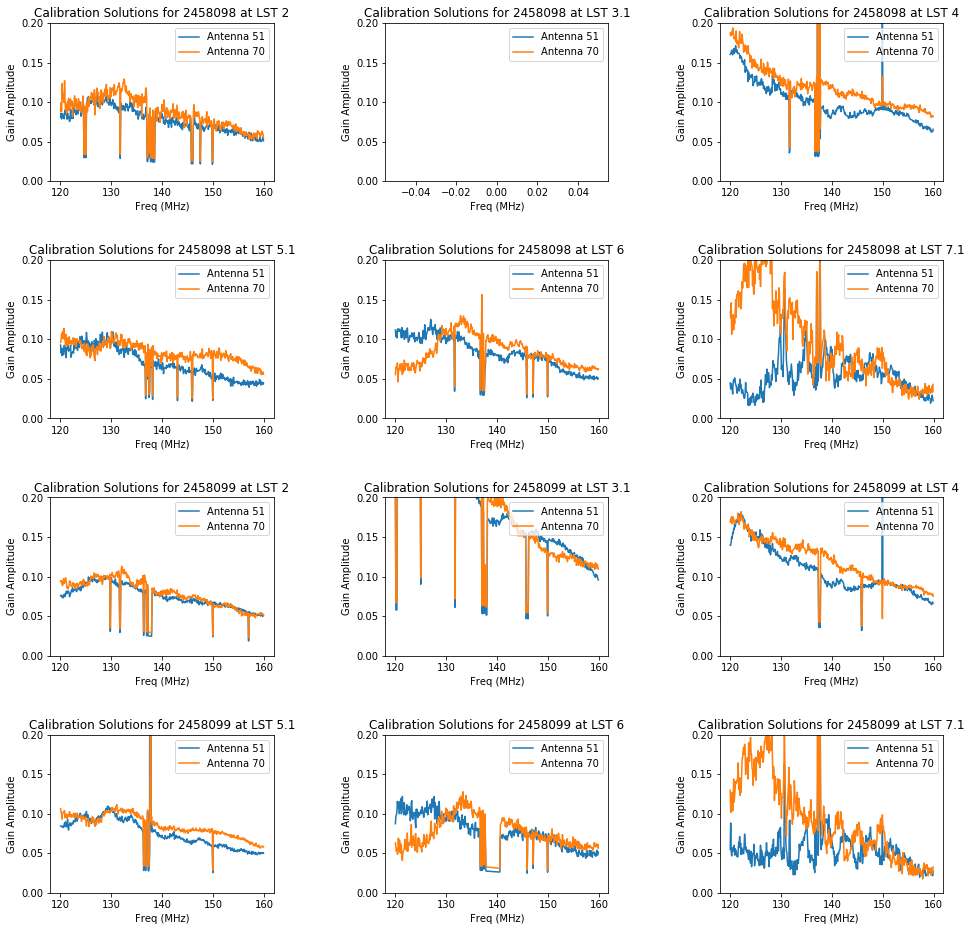

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [402]:
outdir = '/lustre/aoc/projects/hera/dstorer/Projects/plotScripts/movieFrames/horizontalCutGrids'
lsts = [[2,3.1,4],[5.1,6,7.1]]
fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
antennas = [51,70]
n = 0
freqs = [120,160]
print(days[k])
for k in range(len(days)):
    for i in range(len(lsts)):
        for j in range(len(lsts[0])):        
            lst = lsts[i][j]
            xlabel = False
            ylabel = False
            if k == len(days)-1 and i == len(freqs)-1:
                xlabel = True
            if j == 0:
                ylabel = True
            plotHorizontalCut_withAxes(data_array,days[k],lst,axes[n][j],xlabel,ylabel,antennas=antennas,freq_range=freqs)
        n = n + 1

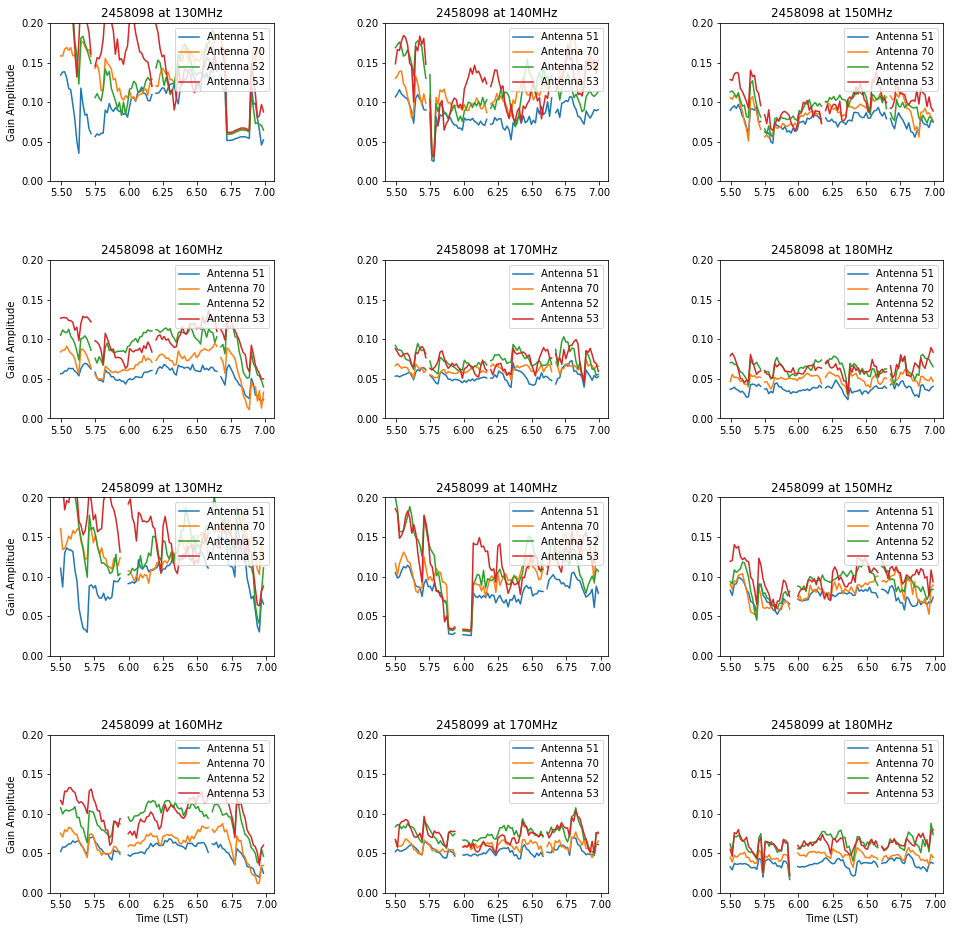

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [368]:
outdir = '/lustre/aoc/projects/hera/dstorer/Projects/plotScripts/movieFrames/verticalCutGrids'
freqs = [[130,140,150],[160,170,180]]
fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
antennas = [51,70,52,53]
n = 0
times = [2,8]
times = [5.5,7]
for k in range(len(days)):
    for i in range(len(freqs)):
        for j in range(len(freqs[0])):        
            freq = freqs[i][j]
            xlabel = False
            ylabel = False
            if k == len(days)-1 and i == len(freqs)-1:
                xlabel = True
            if j == 0:
                ylabel = True
            plotVerticalCut_withAxes(data_array,days[k],freq,axes[n][j],xlabel,ylabel,antennas=antennas,lst_range=times)
        n = n + 1

In [291]:
freqs = []
lsts = []
for f in freqs:
    fig, axs = plt.subplots(1, len(lsts))
    fig.subplots_adjust(hspace=0.5,wspace=0.5)
    fig.subplots_adjust(right=0.8)
    for t in range(len(lst)):
        lst = lsts[t]
        fig = 

SyntaxError: invalid syntax (<ipython-input-291-0129257b717e>, line 9)

(421, 666)
(421,)
(421,)
(421, 666)
(421,)
(421,)


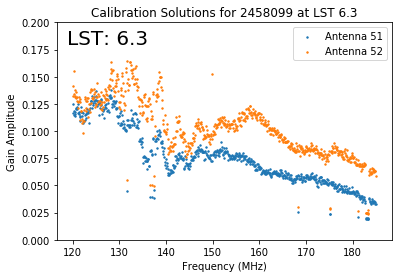

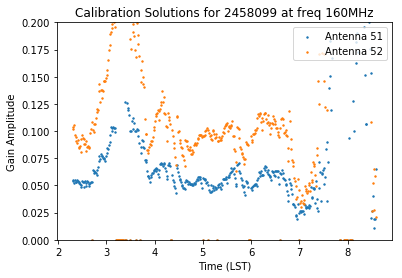

In [169]:
plotHorizontalCut(data_array,'2458099',6.3)
plotVerticalCut(data_array,'2458099',160)

In [224]:
k = 0
j = 0
freq_range = [120,180]
lst_range = [2,8]
mx = data_array[days[k]][j]["masked_data"]
freq_array = data_array[days[k]][j]["freq_array"]
time_array = data_array[days[k]][j]["lst_array"]
jd_array = data_array[days[k]][j]["time_array"]
zens = data_array[days[k]][j]["zenith_RA_array"]
idx0 = (np.abs(freq_array - freq_range[0])).argmin()
idx1 = (np.abs(freq_array - freq_range[1])).argmin()
freq_array = freq_array[idx0:idx1]
mx = mx[:,idx0:idx1]
idx0 = (np.abs(time_array - np.asarray(lst_range[0]))).argmin()
idx1 = (np.abs(time_array - np.asarray(lst_range[1]))).argmin()
time_array = time_array[idx0:idx1]
mx = mx[idx0:idx1,:]


print(np.shape(mx))
print(np.shape(freq_array))
print(np.shape(time_array))
print(np.shape(jd_array))

(391, 614)
(614,)
(391,)
(859,)
